# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster. It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. This notebook also demonstrates the bias introduced on the reconstructed mass by a naive fit, when the redshift distribution of the background galaxies is not properly accounted for in the model.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from scipy.stats import chi2
import corner

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [2]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from sampler import fitters

clmm.__version__

'0.3.0'

Next, we import `clmm`'s core modules.

In [3]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [4]:
import mock_data as mock

## Making mock data

For reproducibility:

In [5]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [6]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [7]:
cosmo = mock_cosmo
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 10000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [8]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,0.8)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13')
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13', 
                                            shapenoise=0.05, 
                                            photoz_sigma_unscaled=0.05)

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [9]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_ideal_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data_z)
gc_object.save('ideal_GC_z.pkl')

cluster_id = "CL_noisy_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
gc_object.save('noisy_GC_z.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [10]:
cl1 = clmm.GalaxyCluster.load('ideal_GC.pkl') # all background galaxies at the same redshift
cl2 = clmm.GalaxyCluster.load('ideal_GC_z.pkl') # background galaxies distributed according to Chang et al. (2013)
cl3 = clmm.GalaxyCluster.load('noisy_GC_z.pkl') # same as cl2 but with photoz error and shape noise

print("Cluster info = ID:", cl2.unique_id, "; ra:", cl2.ra, "; dec:", cl2.dec, "; z_l :", cl2.z)
print("The number of source galaxies is :", len(cl2.galcat))

Cluster info = ID: CL_ideal_z ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


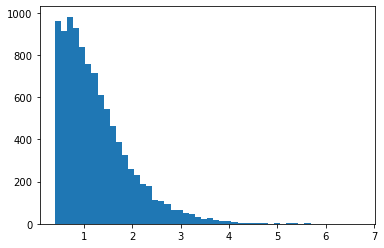

In [11]:
h = plt.hist(cl2.galcat['z'], bins=50)

## Deriving observables

### Computing shear

`clmm.polaraveraging.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [12]:
theta1, g_t1, g_x1 = cl1.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t2, g_x2 = cl2.compute_tangential_and_cross_components(geometry="flat")
theta3, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat")

### Radially binning the data

In [13]:
bin_edges = pa.make_bins(0.7, 4, 15, method='evenlog10width')

`clmm.polaraveraging.make_binned_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [14]:
profile1 = cl1.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile2 = cl2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile3 = cl3.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

After running `clmm.polaraveraging.make_binned_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [15]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.534e-01  7.863e-01 5.315e-02 2.245e-04  1.101e-18 6.322e-19 8.000e-01 2.177e-17 2.600e+01
 7.863e-01 8.328e-01  8.831e-01 4.956e-02 1.850e-04 -3.854e-19 1.324e-18 8.000e-01 1.734e-17 4.100e+01
 8.831e-01 9.295e-01  9.920e-01 4.571e-02 1.446e-04  3.469e-19 1.456e-18 8.000e-01 3.140e-17 5.000e+01
 9.920e-01 1.055e+00  1.114e+00 4.142e-02 1.410e-04 -1.742e-19 6.771e-19 8.000e-01 1.484e-17 5.600e+01
 1.114e+00 1.188e+00  1.251e+00 3.758e-02 1.202e-04  5.692e-19 8.028e-19 8.000e-01 1.241e-17 8.000e+01
 1.251e+00 1.327e+00  1.406e+00 3.416e-02 1.072e-04  1.557e-19 8.000e-19 8.000e-01 1.121e-17 9.800e+01
 1.406e+00 1.492e+00  1.579e+00 3.071e-02 8.676e-05 -7.310e-20 2.858e-19 8.000e-01 1.933e-17 1.320e+02
 1.579e+00 1.682e+00  1.773e+00 2.740e-02 7.352e-05 -2.861e-19 4.593e-19 

We visualize the radially binned shear for the 3 configurations

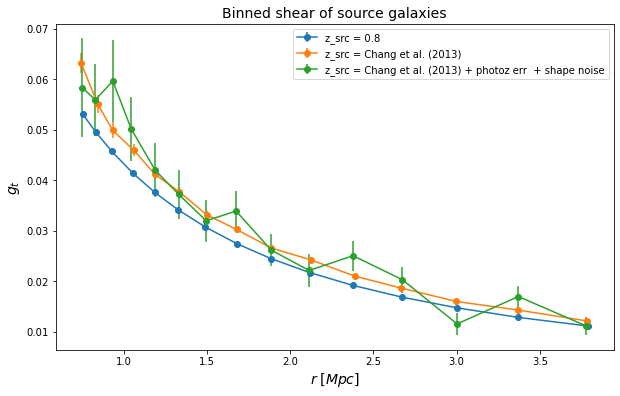

In [16]:
fig = plt.figure(figsize=(10, 6))


fsize = 14
fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], marker='o', label='z_src = 0.8')
fig.gca().errorbar(profile2['radius'], profile2['gt'], yerr=profile2['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013)')
fig.gca().errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013) + photoz err  + shape noise')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)
plt.legend()

### Fitting a halo mass - highlighting bias when not accounting for the source redshift distribution in the model

We estimate the best-fit mass using a simple implementation of the likelihood using a NcmDataGaussDiag object.

Here, to build the model we make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This should not impact `cluster 1` as all sources are located at the same redshift. However, this yields a bias in the econstructed mass for `cluster 2` and `cluster 3`, where the sources followed the Chang et al. (2013) distribution.

As expected, the reconstructed mass is biased whenever the sources are not located at a single redshift as this was not accounted for in the model.

## Create the halo model

Here we model using the OO inteface, we also use NumCosmo statistical framework to perform the analysis. Below we create an object based on NumCosmo NcmDataGaussDiag (Gaussian likelihood with a diagonal covariance matrix) object . To connect with the C interface the object must implement the methods: do_get_length, do_get_dof, do_begin, do_prepare and do_mean_func. The last method is responsible to compute the theoretical predictions. In the param_set_ftype calls below one can change between FREE/FIXED to include/exclude the parameter from the analysis. 

Remember that here we are building the wrong model.

In [17]:
class GaussGammaTErr (Ncm.DataGaussDiag):
    z_cluster = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    z_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    r_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    z_err     = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)

    def __init__ (self):
        Ncm.DataGaussDiag.__init__ (self, n_points = 0)        
        self.moo = clmm.Modeling ()
    
    def init_from_data (self, z_cluster, r_source, z_source, gt_profile, gt_err, z_err = None, moo = None):
        
        if moo:
            self.moo = moo
        
        assert len (gt_profile) == len (z_source)
        assert len (gt_profile) == len (r_source)
        assert len (gt_profile) == len (gt_err)
        
        self.set_size (len (gt_profile))
        
        self.props.z_cluster = z_cluster
        self.props.z_source  = Ncm.Vector.new_array (z_source)
        self.props.r_source  = Ncm.Vector.new_array (r_source)
        if z_err:
            self.props.r_source  = Ncm.Vector.new_array (z_err)
                
        self.y.set_array (gt_profile)
        
        self.sigma.set_array (gt_err)
        
        self.set_init (True)        
    
    def do_get_length (self):
        return self.np

    def do_get_dof (self):
        return self.np

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        self.moo.set_mset (mset)
        
    def do_mean_func (self, mset, vp):
        vp.set_array (self.moo.eval_reduced_shear (self.props.r_source.dup_array (), self.props.z_cluster, self.props.z_source.dup_array ()))
        return

GObject.type_register (GaussGammaTErr)

moo1 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo1.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo1.set_concentration (4.0)

moo2 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo2.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo2.set_concentration (4.0)

moo3 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo3.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo3.set_concentration (4.0)

ggt1 = GaussGammaTErr ()
ggt2 = GaussGammaTErr ()
ggt3 = GaussGammaTErr ()

ggt1.init_from_data (z_cluster = cluster_z, r_source = profile1['radius'] * cosmo.h, z_source = profile1['z'], gt_profile = profile1['gt'], gt_err = profile1['gt_err'], moo = moo1)
ggt2.init_from_data (z_cluster = cluster_z, r_source = profile2['radius'] * cosmo.h, z_source = profile2['z'], gt_profile = profile2['gt'], gt_err = profile2['gt_err'], moo = moo2)
ggt3.init_from_data (z_cluster = cluster_z, r_source = profile3['radius'] * cosmo.h, z_source = profile3['z'], gt_profile = profile3['gt'], gt_err = profile3['gt_err'], moo = moo3)

mset1 = ggt1.moo.get_mset ()
mset2 = ggt2.moo.get_mset ()
mset3 = ggt3.moo.get_mset ()

MDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset1.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset1.prepare_fparam_map ()

mset2.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset2.prepare_fparam_map ()

mset3.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset3.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset3.prepare_fparam_map ()

dset1 = Ncm.Dataset.new ()
dset1.append_data (ggt1)
lh1 = Ncm.Likelihood.new (dset1)

dset2 = Ncm.Dataset.new ()
dset2.append_data (ggt2)
lh2 = Ncm.Likelihood.new (dset2)

dset3 = Ncm.Dataset.new ()
dset3.append_data (ggt3)
lh3 = Ncm.Likelihood.new (dset3)

fit1 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh1, mset1, Ncm.FitGradType.NUMDIFF_FORWARD)
fit2 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh2, mset2, Ncm.FitGradType.NUMDIFF_FORWARD)
fit3 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh3, mset3, Ncm.FitGradType.NUMDIFF_FORWARD)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.fisher ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.fisher ()
fit2.log_covar ()

fit3.run (Ncm.FitRunMsgs.SIMPLE)
fit3.fisher ()
fit3.log_covar ()


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0089850
#  iteration            [000060]
#  function evaluations [000062]
#  gradient evaluations [000000]
#  degrees of freedom   [000013]
#  m2lnL     =  0.00613350190095587 (  0.0061335019 )
#  Fit parameters:
#     3.99544746141028     15.1558024847899    
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                       -------------------------------
#      cDelta[04000:00] =  3.995       +/-  0.01283     |  1           | -0.6125      |
# log10MDelta[04000:01] =  15.16       +/-  0.0004736   | -0.6125      |  1          

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [18]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl1.galcat['z']))
gt_model2 = moo2.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl2.galcat['z']))
gt_model3 = moo3.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl3.galcat['z']))

m_est1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo1.cor_factor
m_est2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo2.cor_factor
m_est3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo3.cor_factor

m_est_err1 = fit1.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est1 * math.log (10.0)
m_est_err2 = fit2.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est2 * math.log (10.0)
m_est_err3 = fit3.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est3 * math.log (10.0)

print ("% 22.15e +/- %.0e % 22.15e +/- %.0e % 22.15e +/- %.0e" % (m_est1, m_est_err1, m_est2, m_est_err2, m_est3, m_est_err3))

 1.001818668285154e+15 +/- 1e+12  8.681293052700950e+14 +/- 5e+12  8.629291524163696e+14 +/- 7e+13


We visualize that prediction of reduced tangential shear along with the data

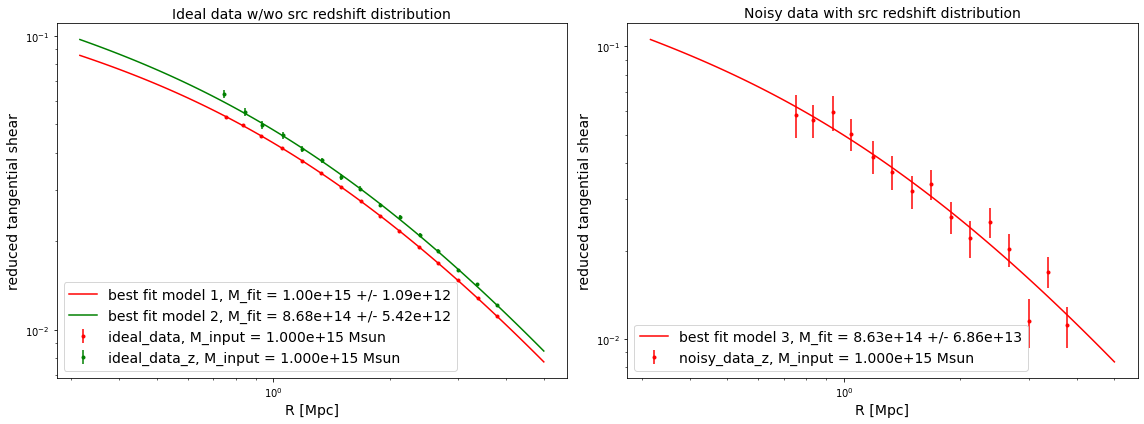

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'], color='red',
                 label='ideal_data, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model1,color='red',
             label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est1, m_est_err1))


axes[0].errorbar(profile2['radius'], profile2['gt'],profile2['gt_err'], color='green',
                  label='ideal_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model2, color='green',
               label='best fit model 2, M_fit = %.2e +/- %.2e' % (m_est2, m_est_err2))
axes[0].set_title('Ideal data w/wo src redshift distribution',fontsize=fsize)
axes[0].semilogx()
axes[0].semilogy()
axes[0].legend(fontsize=fsize)
axes[0].set_xlabel('R [Mpc]', fontsize=fsize)
axes[0].set_ylabel('reduced tangential shear', fontsize=fsize)

axes[1].errorbar(profile3['radius'], profile3['gt'],profile3['gt_err'], color='red',
                label='noisy_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[1].plot(rr, gt_model3,color='red',
             label='best fit model 3, M_fit = %.2e +/- %.2e' % (m_est3, m_est_err3))
axes[1].set_title('Noisy data with src redshift distribution',fontsize=fsize)
axes[1].semilogx()
axes[1].semilogy()
axes[1].legend(fontsize=fsize)
axes[1].set_xlabel('R [Mpc]', fontsize=fsize)
axes[1].set_ylabel('reduced tangential shear', fontsize=fsize)

fig.tight_layout()

### To investigate further the results we make a MCMC analysis below.

In the end we save the catalog to mcat_wrong to compare with a correct analysis.

In [20]:
Ncm.func_eval_set_max_threads (0)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset3)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 100
stretch = Ncm.FitESMCMCWalkerAPS.new (nwalkers, mset3.fparams_len ())

esmcmc  = Ncm.FitESMCMC.new (fit3, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file ("example2_fit3_wrong_esmcmc_out_aps.fits")
esmcmc.set_auto_trim (True)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)

esmcmc.start_run ()
esmcmc.run_lre (20, 1.0e-3)
esmcmc.end_run ()

mcat_wrong = esmcmc.peek_catalog ()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      0
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 3903990095.
# NcmMSetCatalog: Current mean:   17.011       4.2629       15.087     
# NcmMSetCatalog: Current msd:    0.76588      0.0010509    0.0054337  
# NcmMSetCatalog: Current sd:     7.6588       0.010509     0.054337   
# NcmMSetCatalog: Current var:    58.657       0.00011044   0.0029525  
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------

# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 3.181471e-03
# NcmFitESMCMC: ln (eVol) =      -2.14979438024555; ln (gVol) =      -2.05495975283061; lnNorm =       -7.8476533612255
# NcmFitESMCMC: Running more 92 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000092] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:49:59
# NcmMSetCatalog: Current mean:   13.171       4.4616       15.085     
# NcmMSetCatalog: Current msd:    0.027505     0.013676     0.00047969 
# NcmMSetCatalog: Current sd:     2.1742       0.77365      0.034558   
# NcmMSetCatalog: Current var:    4.727        0.59854      0.0011942  
# NcmMSetCatalog: Current tau:    1.7285       3.3751       2.0809     
# NcmMSetCatalog: Current skfac:  1.0028       1.0018       1.0007     
# NcmMSetCatalog: Maximal Shrink factor = 1.00217               
#-------------------------

# NcmMSetCatalog: - best cutoff time:         10  
# NcmMSetCatalog: - total number of points:   192  (19200)
# NcmMSetCatalog: - number of points left:    182  (18200)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      109.09
# NcmMSetCatalog: - worst parameter ar order: 2   
# NcmMSetCatalog: - ess's:                    117.78 109.09 184.13
# NcmMSetCatalog: Trimming the catalog at: 10.
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.718209e-03
# NcmFitESMCMC: ln (eVol) =      -2.08902613552177; ln (gVol) =      -2.03974747251872; lnNorm =      -7.83143444721313
# NcmFitESMCMC: Running more 36 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000036] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:00
# NcmMSetCatalog: Current mean:   13.216       4.4748     

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   218  (21800)
# NcmMSetCatalog: - number of points left:    218  (21800)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      136.63
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    136.63 143.57 218.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.496229e-03
# NcmFitESMCMC: ln (eVol) =      -2.09094526407995; ln (gVol) =      -2.04284964466757; lnNorm =      -7.83161928661958
# NcmFitESMCMC: Running more 28 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000028] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:00
# NcmMSetCatalog: Current mean:   13.202       4.4752       15.085     
# NcmMSetCatalog: Current msd:    0.01696      0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   246  (24600)
# NcmMSetCatalog: - number of points left:    246  (24600)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      153.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    153.00 169.86 246.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.378224e-03
# NcmFitESMCMC: ln (eVol) =      -2.08828035616904; ln (gVol) =      -2.03834855750203; lnNorm =      -7.82977280455155
# NcmFitESMCMC: Running more 23 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000023] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:00
# NcmMSetCatalog: Current mean:   13.209       4.4762       15.085     
# NcmMSetCatalog: Current msd:    0.01601      0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   269  (26900)
# NcmMSetCatalog: - number of points left:    269  (26900)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      169.30
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    169.30 186.04 269.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.321117e-03
# NcmFitESMCMC: ln (eVol) =      -2.08497447892429; ln (gVol) =      -2.03418029859076; lnNorm =      -7.82867206691607
# NcmFitESMCMC: Running more 21 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000021] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:01
# NcmMSetCatalog: Current mean:   13.213       4.4797       15.085     
# NcmMSetCatalog: Current msd:    0.015331     0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   290  (29000)
# NcmMSetCatalog: - number of points left:    290  (29000)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      188.18
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    188.18 197.07 244.15
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.282494e-03
# NcmFitESMCMC: ln (eVol) =      -2.08668757735388; ln (gVol) =      -2.03530439699933; lnNorm =      -7.82982706796681
# NcmFitESMCMC: Running more 19 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000019] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:02
# NcmMSetCatalog: Current mean:   13.214       4.4816       15.085     
# NcmMSetCatalog: Current msd:    0.014522     0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   309  (30900)
# NcmMSetCatalog: - number of points left:    309  (30900)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      200.20
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    200.20 212.25 309.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.235206e-03
# NcmFitESMCMC: ln (eVol) =        -2.084630261089; ln (gVol) =      -2.03439716651767; lnNorm =      -7.82955438911881
# NcmFitESMCMC: Running more 17 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000017] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:02
# NcmMSetCatalog: Current mean:   13.215       4.4838       15.085     
# NcmMSetCatalog: Current msd:    0.014114     0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   326  (32600)
# NcmMSetCatalog: - number of points left:    326  (32600)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      219.01
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    219.01 233.05 326.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.179832e-03
# NcmFitESMCMC: ln (eVol) =       -2.0851988691622; ln (gVol) =      -2.03471958071462; lnNorm =      -7.82955270743041
# NcmFitESMCMC: Running more 13 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000013] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:03
# NcmMSetCatalog: Current mean:   13.216       4.4834       15.085     
# NcmMSetCatalog: Current msd:    0.01348      0

# NcmMSetCatalog: - best cutoff time:         4   
# NcmMSetCatalog: - total number of points:   339  (33900)
# NcmMSetCatalog: - number of points left:    335  (33500)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      234.99
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    234.99 238.87 284.80
# NcmMSetCatalog: Trimming the catalog at: 4.
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.168638e-03
# NcmFitESMCMC: ln (eVol) =       -2.0843768613522; ln (gVol) =      -2.03361642988828; lnNorm =      -7.82912397930183
# NcmFitESMCMC: Running more 13 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000013] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:03
# NcmMSetCatalog: Current mean:   13.217       4.485        15.085     
# 

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   348  (34800)
# NcmMSetCatalog: - number of points left:    348  (34800)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      237.15
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    237.15 251.62 292.87
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.134538e-03
# NcmFitESMCMC: ln (eVol) =      -2.08464427776353; ln (gVol) =      -2.03546298902444; lnNorm =      -7.82976268349569
# NcmFitESMCMC: Running more 11 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000011] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:04
# NcmMSetCatalog: Current mean:   13.214       4.4841       15.085     
# NcmMSetCatalog: Current msd:    0.012918     0

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   359  (35900)
# NcmMSetCatalog: - number of points left:    359  (35900)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      197.78
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    239.17 197.78 301.68
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.277005e-03
# NcmFitESMCMC: ln (eVol) =       -2.0868061623066; ln (gVol) =      -2.03832607801858; lnNorm =      -7.83042907181763
# NcmFitESMCMC: Running more 23 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000023] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:04
# NcmMSetCatalog: Current mean:   13.209       4.481        15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         28  
# NcmMSetCatalog: - total number of points:   382  (38200)
# NcmMSetCatalog: - number of points left:    354  (35400)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      197.50
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    223.50 197.50 354.00
# NcmMSetCatalog: Trimming the catalog at: 28.
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.275021e-03
# NcmFitESMCMC: ln (eVol) =      -2.08720678787116; ln (gVol) =      -2.04110890260369; lnNorm =      -7.83139921830762
# NcmFitESMCMC: Running more 23 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000023] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:05
# NcmMSetCatalog: Current mean:   13.205       4.4817     

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   377  (37700)
# NcmMSetCatalog: - number of points left:    377  (37700)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      224.42
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    235.49 224.42 377.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.196337e-03
# NcmFitESMCMC: ln (eVol) =      -2.08936467930732; ln (gVol) =      -2.04159132158005; lnNorm =      -7.83223877385184
# NcmFitESMCMC: Running more 17 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000017] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:06
# NcmMSetCatalog: Current mean:   13.205       4.4818       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         32  
# NcmMSetCatalog: - total number of points:   394  (39400)
# NcmMSetCatalog: - number of points left:    362  (36200)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      241.66
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    241.66 256.60 362.00
# NcmMSetCatalog: Trimming the catalog at: 32.
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.122105e-03
# NcmFitESMCMC: ln (eVol) =      -2.08716845986376; ln (gVol) =      -2.03879295513533; lnNorm =      -7.83052971847515
# NcmFitESMCMC: Running more 10 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000010] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:07
# NcmMSetCatalog: Current mean:   13.204       4.4803       15.085     
#

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   397  (39700)
# NcmMSetCatalog: - number of points left:    397  (39700)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      211.70
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    267.55 211.70 397.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.239718e-03
# NcmFitESMCMC: ln (eVol) =      -2.08798110030297; ln (gVol) =      -2.03652630147489; lnNorm =      -7.83069066916651
# NcmFitESMCMC: Running more 22 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000022] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:08
# NcmMSetCatalog: Current mean:   13.208       4.4803       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   419  (41900)
# NcmMSetCatalog: - number of points left:    419  (41900)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      226.65
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    268.38 226.65 419.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.199586e-03
# NcmFitESMCMC: ln (eVol) =      -2.08770362167587; ln (gVol) =      -2.03482727390644; lnNorm =      -7.83064684555876
# NcmFitESMCMC: Running more 19 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000019] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:09
# NcmMSetCatalog: Current mean:   13.21        4.4821       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   438  (43800)
# NcmMSetCatalog: - number of points left:    438  (43800)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      236.86
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    283.52 236.86 438.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.174956e-03
# NcmFitESMCMC: ln (eVol) =      -2.08728527173926; ln (gVol) =      -2.03279058943623; lnNorm =      -7.83053733728909
# NcmFitESMCMC: Running more 17 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000017] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:09
# NcmMSetCatalog: Current mean:   13.212       4.4836       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   455  (45500)
# NcmMSetCatalog: - number of points left:    455  (45500)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      250.53
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    287.75 250.53 455.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.140223e-03
# NcmFitESMCMC: ln (eVol) =      -2.08951923856556; ln (gVol) =      -2.03591229198452; lnNorm =      -7.83158274430379
# NcmFitESMCMC: Running more 14 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000014] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:10
# NcmMSetCatalog: Current mean:   13.207       4.4827       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   469  (46900)
# NcmMSetCatalog: - number of points left:    469  (46900)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      260.50
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    293.15 260.50 469.00
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.116835e-03
# NcmFitESMCMC: ln (eVol) =      -2.09183042880958; ln (gVol) =      -2.03800668597818; lnNorm =      -7.83232112997269
# NcmFitESMCMC: Running more 12 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000012] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:11
# NcmMSetCatalog: Current mean:   13.205       4.4828       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   481  (48100)
# NcmMSetCatalog: - number of points left:    481  (48100)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      269.94
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    303.47 269.94 418.33
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.097508e-03
# NcmFitESMCMC: ln (eVol) =      -2.09093709350157; ln (gVol) =      -2.03749667421516; lnNorm =      -7.83194242311037
# NcmFitESMCMC: Running more 10 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000010] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:11
# NcmMSetCatalog: Current mean:   13.206       4.4827       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   491  (49100)
# NcmMSetCatalog: - number of points left:    491  (49100)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      274.14
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    304.06 274.14 429.48
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.091602e-03
# NcmFitESMCMC: ln (eVol) =      -2.08889854639386; ln (gVol) =      -2.03450778692644; lnNorm =      -7.83125062580502
# NcmFitESMCMC: Running more 10 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000010] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:12
# NcmMSetCatalog: Current mean:   13.21        4.4831       15.085     
# NcmMSetCatalog: Current msd:   

# NcmMSetCatalog: - best cutoff time:         6   
# NcmMSetCatalog: - total number of points:   501  (50100)
# NcmMSetCatalog: - number of points left:    495  (49500)
# NcmMSetCatalog: - worst parameter:          NcHaloDensityProfile:cDelta[01]
# NcmMSetCatalog: - worst parameter ess:      285.56
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    306.11 285.56 424.89
# NcmMSetCatalog: Trimming the catalog at: 6.
# NcmFitESMCMC: Largest relative error 1.000000e-03 not attained: 1.069725e-03
# NcmFitESMCMC: ln (eVol) =      -2.08762661781518; ln (gVol) =      -2.03386005965028; lnNorm =      -7.83101723722366
# NcmFitESMCMC: Running more 10 runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000010] Ensemble Sampler Markov Chain Monte Carlo runs [APS-Move]
# Task:NcmFitESMCMC, started at: Mon Sep 21 2020, 12:50:13
# NcmMSetCatalog: Current mean:   13.211       4.4836      

# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   505  (50500)
# NcmMSetCatalog: - number of points left:    505  (50500)
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      320.76
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    320.76 370.90 427.53
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Largest relative error 1.000000e-03 attained: 9.387296e-04
# NcmMSetCatalog: Current mean:   13.212       4.4843       15.085     
# NcmMSetCatalog: Current msd:    0.011183     0.0042095    0.00016779 
# NcmMSetCatalog: Current sd:     2.0028       0.8107       0.034693   
# NcmMSetCatalog: Current var:    4.0111       0.65723      0.0012036  
# NcmMSetCatalog: Current tau:    1.5744       1.3616       1.1812     


## Correct non- projected model

Here, instead of build a object directly on top of NcmDataGauss* we use NumCosmo's framework to build non-binned likelihood for weak-lensing cluster analysis.

For that we need two objects: a NcGalaxyWLReducedShearGauss that model a Gaussian distributed reduced shear likelihood, here the observables matrix is simply $(r, \gamma_t, \sigma_{\gamma_t})$ for each galaxy. If the data has spectroscopic redshifts then we use NcGalaxyRedshiftSpec with an array of real redshifts. When photometric errors are included we use the NcGalaxyRedshiftGauss object that receives $(z, \sigma_z)$ for each cluster. 

Once we have the data objects ready we can proceed as in the previous examples.


In [21]:
def create_nc_data_cluster_wl (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r  = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    ga = Ncm.ObjArray.new ()
    
    sigma_g = 1.0e-4 if not sigma_g else sigma_g
    m_obs = np.column_stack ((r, g_t, np.repeat (sigma_g, len (r))))
    
    grsg = Nc.GalaxyWLReducedShearGauss (pos = Nc.GalaxyWLReducedShearGaussPos.R)
    grsg.set_obs (Ncm.Matrix.new_array (m_obs.flatten (), 3))
    
    if sigma_z:
        gzgs = Nc.GalaxyRedshiftGauss ()
        z_obs = np.column_stack ((z_source, (1.0 + z_source) * sigma_z))
        gzgs.set_obs (Ncm.Matrix.new_array (z_obs.flatten (), 2))
    else:
        gzgs = Nc.GalaxyRedshiftSpec ()
        gzgs.set_z (Ncm.Vector.new_array (z_source))

    gwl  = Nc.GalaxyWL (wl_dist = grsg, gz_dist = gzgs)
    ga.add (gwl)

    nc_dcwl = Nc.DataClusterWL (galaxy_array = ga, z_cluster = z_cluster)
    nc_dcwl.set_init (True)
    
    return nc_dcwl

def create_fit_obj (data_array, mset):
    dset = Ncm.Dataset.new ()
    for data in data_array:
        dset.append_data (data)
    lh = Ncm.Likelihood.new (dset)
    fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)
    #fit.set_params_reltol (1.0e-8)
    #fit.set_m2lnL_reltol (1.0e-11)
    
    return fit

ggt1 = create_nc_data_cluster_wl (theta1, g_t1, cl1.galcat['z'], cluster_z, cosmo, moo1.dist, sigma_z = None, sigma_g = None)
ggt2 = create_nc_data_cluster_wl (theta2, g_t2, cl2.galcat['z'], cluster_z, cosmo, moo1.dist, sigma_z = None, sigma_g = None)
ggt3 = create_nc_data_cluster_wl (theta3, g_t3, cl3.galcat['z'], cluster_z, cosmo, moo1.dist, sigma_z = 0.05, sigma_g = 0.05)
    
fit1 = create_fit_obj ([ggt1], mset1)
fit2 = create_fit_obj ([ggt2], mset2)
fit3 = create_fit_obj ([ggt3], mset3)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.obs_fisher ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.obs_fisher ()
fit2.log_covar ()

fit3.run (Ncm.FitRunMsgs.SIMPLE)
fit3.obs_fisher ()
fit3.log_covar ()

mest1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo1.cor_factor
mest2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo2.cor_factor
mest3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo3.cor_factor

print ("% 22.15e % 22.15e % 22.15e" % (mest1, mest2, mest3))

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.1267420
#  iteration            [000054]
#  function evaluations [000056]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =   0.0391122167739742 (   0.039112217 )
#  Fit parameters:
#     3.99994676013512     15.1550234356027    
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                       -------------------------------
#      cDelta[04000:00] =  4           +/-  0.0004435   |  1           | -0.6262      |
# log10MDelta[04000:01] =  15.16       +/-  5.094e-05   | -0.6262      |  1           

## Visualizing the results

Note that below we no longer have biased results, all results are well within the error bars. Note also that the error bars are substantially smaller than in the binned case.

In [22]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl1.galcat['z']))
gt_model2 = moo2.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl2.galcat['z']))
gt_model3 = moo3.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl3.galcat['z']))

m_est1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo1.cor_factor
m_est2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo2.cor_factor
m_est3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h * moo3.cor_factor

m_est_err1 = fit1.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est1 * math.log (10.0)
m_est_err2 = fit2.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est2 * math.log (10.0)
m_est_err3 = fit3.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est3 * math.log (10.0)

print ("% 22.15e +/- %.0e % 22.15e +/- %.0e % 22.15e +/- %.0e" % (m_est1, m_est_err1, m_est2, m_est_err2, m_est3, m_est_err3))

 1.000023189733959e+15 +/- 1e+11  1.000028848482328e+15 +/- 1e+11  9.888362018390641e+14 +/- 5e+13


### To investigate further the results we make a MCMC analysis below.

In [23]:
Ncm.func_eval_set_max_threads (0)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset3)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 100
stretch = Ncm.FitESMCMCWalkerAPS.new (nwalkers, mset3.fparams_len ())

esmcmc  = Ncm.FitESMCMC.new (fit3, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file ("example2_fit3_esmcmc_out_aps.fits")
esmcmc.set_auto_trim (True)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)

esmcmc.start_run ()
esmcmc.run_lre (20, 1.0e-3)
esmcmc.end_run ()


# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      0
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1225403384.
# NcmMSetCatalog: Current mean:   10059        4.1091       15.152     
# NcmMSetCatalog: Current msd:    1.6513       0.0009995    0.005616   
# NcmMSetCatalog: Current sd:     16.513       0.009995     0.05616    
# NcmMSetCatalog: Current var:    272.68       9.99e-05     0.0031539  
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------

# NcmMSetCatalog: Current mean:   10050        4.1228       15.148     
# NcmMSetCatalog: Current msd:    0.061067     0.0031141    0.00038549 
# NcmMSetCatalog: Current sd:     3.7146       0.18943      0.023449   
# NcmMSetCatalog: Current var:    13.798       0.035882     0.00054984 
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac:  0.99977      1.0022       1.002      
# NcmMSetCatalog: Maximal Shrink factor = 1.00366               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `37':
# NcmMSetCatalog: Constant break point at `2':
# NcmFitESMCMC:acceptance ratio 96.1667% (last update 99.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       3.40509449868915 (2n = 4), min(-2ln(L)) =        10048.121929643.
# Task:NcmFitESMCMC, completed: 3700 of 10000, 

# NcmMSetCatalog: Current mean:   10050        4.1158       15.149     
# NcmMSetCatalog: Current msd:    0.036732     0.0024385    0.00027668 
# NcmMSetCatalog: Current sd:     3.0512       0.20256      0.022983   
# NcmMSetCatalog: Current var:    9.3099       0.04103      0.00052821 
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac:  0.9999       1.0026       1.0033     
# NcmMSetCatalog: Maximal Shrink factor = 1.00348               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `69':
# NcmMSetCatalog: Constant break point at `2':
# NcmFitESMCMC:acceptance ratio 96.7500% (last update 99.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):         6.068912378013 (2n = 4), min(-2ln(L)) =        10048.121929643.
# Task:NcmFitESMCMC, completed: 6900 of 10000, 

# NcmMSetCatalog: Current mean:   10050        4.1158       15.149     
# NcmMSetCatalog: Current msd:    0.027731     0.0020808    0.00022996 
# NcmMSetCatalog: Current sd:     2.7731       0.20808      0.022996   
# NcmMSetCatalog: Current var:    7.6899       0.043298     0.00052882 
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac:  1.0004       1.0025       1.0025     
# NcmMSetCatalog: Maximal Shrink factor = 1.00267               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `100':
# NcmMSetCatalog: Constant break point at `2':
# NcmFitESMCMC:acceptance ratio 96.8586% (last update 96.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       3.42246320676948 (2n = 4), min(-2ln(L)) =        10048.121929643.
# Task:NcmFitESMCMC, completed: 10000 of 10000

### Below we plot both MCMC results

The wrong analysis has a strong bias in $\log_{10}(M_\Delta)$ (the peak of the wrong model is more than $3\sigma$ away from the correct model best-fit) and much larger variance.

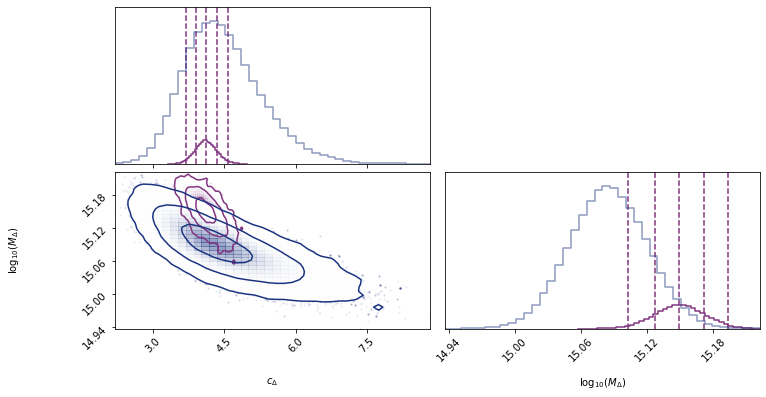

In [24]:

s1d1 = chi2.cdf (1.0, df = 1)
s1d2 = chi2.cdf (4.0, df = 1)
s2d1 = chi2.cdf (1.0, df = 2)
s2d2 = chi2.cdf (4.0, df = 2)
s2d3 = chi2.cdf (9.0, df = 2)
qts = [0.5 - s1d2 / 2.0, 0.5 - s1d1 / 2.0, 0.5, 0.5 + s1d1 / 2.0, 0.5 + s1d2 / 2.0]

mcat = esmcmc.peek_catalog ()
rows = np.array ([mcat.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]
figure = corner.corner (rows[:,1:], labels = params[1:], reverse = False,
                        quantiles=qts, levels = (s2d1, s2d2, s2d3), 
                        bins = 40, smooth = 0.8, smooth1d = 0.8, color = (0.5, 0.2, 0.5, 1.0))

rows = np.array ([mcat_wrong.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat_wrong.len ())])
params = ["$" + mcat_wrong.col_symb (i) + "$" for i in range (mcat_wrong.ncols ())]
figure = corner.corner (rows[:,1:], labels = params[1:], reverse = False,
                        levels = (s2d1, s2d2, s2d3), color = (0.1, 0.2, 0.5, 0.5),
                        bins = 40, smooth = 0.8, smooth1d = 0.8, fig = figure)


figure.set_size_inches(12, 6)

In [25]:
ser = Ncm.Serialize.new (0)
data = fit3.lh.dset.get_data (0)
ser.to_file (data, "example2_fit3_data.obj")